In this project, we are going to explore a key development in the history of Lego: the introduction of licensed sets such as Star Wars, Super Heroes, and Harry Potter.

It may not be widely known, but Lego has had its share of ups and downs since its inception in the early 20th century. This includes a particularly rough period in the late 90s. As described in this article: https://www.businessinsider.com/how-lego-made-a-huge-turnaround-2014-2?r=US&IR=T, Lego was only able to survive due to a successful internal brand (Bionicle) and the introduction of its first licensed series: Star Wars.

There are two main dataset:

lego_sets.csv

- set_num: A code that is unique to each set in the dataset.
- set_name: A name for every set in the dataset.
- year: The date the set was released.
- num_parts: The number of parts contained in the set.
- theme_name: The name of the sub-theme of the set.
- parent_theme: The name of the parent theme the set belongs to. Matches the name column of the parent_themes csv file.

parent_theme.csv

- id: A code that is unique to every theme.
- name: The name of the parent theme.
- is_licensed: A Boolean column specifying whether the theme is a licensed theme.

There are three main questions we want to find out the answers:
1. What percentage of all licensed sets ever released were Star Wars themed?
2. In which year was Star Wars not the most popular licensed theme (in terms of number of sets released that year)?
3. How many unique sets were released each year (1955-2017)?

1. Extracting and reading colors data

In [5]:
! pip install rebrick

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import rebrick
import json

# init rebrick module for general reading
rebrick.init("a9002d62a9a3c58261f0eb7615f127a1")

# get set info
response = rebrick.lego.get_set(6608)
print(json.loads(response.read()))

rebrick.init("a9002d62a9a3c58261f0eb7615f127a1", "littlelion_9508", "karen19950808")

# get user partlists
response = rebrick.users.get_partlists()
print(json.loads(response.read()))

{'set_num': '6608-1', 'name': 'Tractor', 'year': 1982, 'theme_id': 67, 'num_parts': 21, 'set_img_url': 'https://cdn.rebrickable.com/media/sets/6608-1/9875.jpg', 'set_url': 'https://rebrickable.com/sets/6608-1/tractor/', 'last_modified_dt': '2021-07-04T18:43:10.903443Z'}
{'count': 0, 'next': None, 'previous': None, 'results': []}


In [4]:
# Request color data from API
import requests

# Replace with own API key
api_key = "a9002d62a9a3c58261f0eb7615f127a1"

# Construct the API URL
base_url = "https://rebrickable.com/api/v3/"
endpoint = "lego/colors/"
url = f"{base_url}{endpoint}"

# Set headers (including the API key)
headers = {
    "Authorization": f"key {api_key}"
}

# Make the API request
response = requests.get(url, headers=headers)

# Check if the request was successful
if response.status_code == 200:
    data = response.json()
    # Extract the list of colors from the data
    colors_list = data["results"]
    
    # Convert the list of dictionaries to a DataFrame
    df = pd.DataFrame(colors_list)
    
    print(df)
else:
    print("API request failed:", response.text)

     id                 name     rgb  is_trans  \
0    -1            [Unknown]  0033B2     False   
1     0                Black  05131D     False   
2     1                 Blue  0055BF     False   
3     2                Green  237841     False   
4     3       Dark Turquoise  008F9B     False   
..  ...                  ...     ...       ...   
95  183          Pearl White  F2F3F2     False   
96  191  Bright Light Orange  F8BB3D     False   
97  212    Bright Light Blue  9FC3E9     False   
98  216                 Rust  B31004     False   
99  226  Bright Light Yellow  FFF03A     False   

                                         external_ids  
0   {'BrickOwl': {'ext_ids': [0, 28, 29, 30, 31, 3...  
1   {'BrickLink': {'ext_ids': [11], 'ext_descrs': ...  
2   {'BrickLink': {'ext_ids': [7], 'ext_descrs': [...  
3   {'BrickLink': {'ext_ids': [6], 'ext_descrs': [...  
4   {'BrickLink': {'ext_ids': [39], 'ext_descrs': ...  
..                                                ...  
95  {'B

In [5]:
# Read colors data
df.head()

,id,name,rgb,is_trans,external_ids
0,-1,[Unknown],0033B2,False,"{'BrickOwl': {'ext_ids': [0, 28, 29, 30, 31, 3..."
1,0,Black,05131D,False,"{'BrickLink': {'ext_ids': [11], 'ext_descrs': ..."
2,1,Blue,0055BF,False,"{'BrickLink': {'ext_ids': [7], 'ext_descrs': [..."
3,2,Green,237841,False,"{'BrickLink': {'ext_ids': [6], 'ext_descrs': [..."
4,3,Dark Turquoise,008F9B,False,"{'BrickLink': {'ext_ids': [39], 'ext_descrs': ..."


In [6]:
# Make some changes on the 'colors' dataset, and read the first 5 rows
colors = df.drop('external_ids', axis = 1, inplace = False)
colors = colors.drop(colors.index[0], axis=0)
colors.reset_index(drop = True)
colors.head(5)

,id,name,rgb,is_trans
1,0,Black,05131D,False
2,1,Blue,0055BF,False
3,2,Green,237841,False
4,3,Dark Turquoise,008F9B,False
5,4,Red,C91A09,False


2. Exploring colors data

In [21]:
colors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 1 to 99
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        99 non-null     int64 
 1   name      99 non-null     object
 2   rgb       99 non-null     object
 3   is_trans  99 non-null     bool  
dtypes: bool(1), int64(1), object(2)
memory usage: 2.5+ KB


In [19]:
# How many distinct colors are available?
num_colors = colors['name'].nunique()
# Print num_colors
print(num_colors)

99


2.1 Transparent Colors in Lego Sets
- The colors data has a column named is_trans that indicates whether a color is transparent or not. It would be interesting to explore the distribution of transparent vs. non-transparent colors.

In [22]:
# colors_summary: Distribution of colors based on transparency
groupby_ = colors['is_trans']
agg_ = {
    'id':'count',
    'name':'count',
    'rgb':'count'
}

colors_summary = colors.groupby(by = groupby_).agg(agg_)
colors_summary

,id,name,rgb
is_trans,,,
False,79,79,79
True,20,20,20


-------------------------------------------------------------------------------------------

### Question:
1. What percentage of all licensed sets ever released were Star Wars themed?
2. In which year was Star Wars not the most popular licensed theme (in terms of number of sets released that year)?
3. How many unique sets were released each year (1955-2017)

1. Extracting and reading Lego Sets data
- Lego sets data contains a comprehensive list of sets over the years and the number of parts that each of these sets contained.

In [7]:
%matplotlib inline
# Read sets data as `sets`
sets = pd.read_csv('lego_sets.csv')
sets

,set_num,name,year,num_parts,theme_name,parent_theme
0,00-1,Weetabix Castle,1970,471.0,Castle,Legoland
1,0011-2,Town Mini-Figures,1978,NaN,Supplemental,Town
2,0011-3,Castle 2 for 1 Bonus Offer,1987,NaN,Lion Knights,Castle
3,0012-1,Space Mini-Figures,1979,12.0,Supplemental,Space
4,0013-1,Space Mini-Figures,1979,12.0,Supplemental,Space
...,...,...,...,...,...,...
11981,NaN,NaN,2014,NaN,NaN,Minecraft
11982,NaN,NaN,2006,NaN,NaN,Super Heroes
11983,NaN,NaN,2017,NaN,NaN,Minecraft
11984,NaN,NaN,2017,8.0,NaN,Super Heroes


In [8]:
sets.shape

(11986, 6)

In [25]:
# check the missing values
sets.isnull().sum()

set_num          153
name             153
year               0
num_parts       5060
theme_name       153
parent_theme       0
dtype: int64

In [30]:
# Create a summary of average number of parts by year: `parts_by_year`
groupby_ = sets['year']
agg_ = {
    'num_parts':'mean'
}

parts_by_year = round(sets.groupby(by = groupby_).agg(agg_), 2)
parts_by_year.head(5)

,num_parts
year,
1950,8.67
1953,1.00
1954,17.43
1955,45.17
1956,11.89


<Figure size 800x600 with 0 Axes>

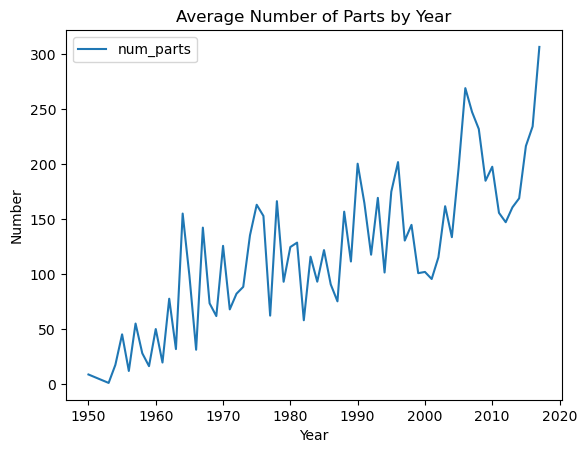

In [31]:
# Plot trends in average number of parts by year
plt.figure(figsize = (8,6))
parts_by_year.plot()
plt.xlabel('Year')
plt.ylabel('Number')
plt.title('Average Number of Parts by Year')
plt.show() # As we can see, the average number of parts increased by years

1. 1 Extracting and reading Lego Themes data

In [33]:
# Read themes data as `themes`
themes = pd.read_csv('parent_themes.csv')
themes.head(5)

,id,name,is_licensed
0,1,Technic,False
1,22,Creator,False
2,50,Town,False
3,112,Racers,False
4,126,Space,False


2. Exploring Lego Themes data

In [35]:
themes.shape

(111, 3)

In [38]:
# Noticed that "parent_theme" column in 'sets' table matches with "name" column in 'themes' table
# Let's merge these two table based on these two columns.
join = pd.merge(sets, themes, left_on = 'parent_theme', right_on = 'name', how = 'left')
join.drop('name_y', axis = 1, inplace = True)
join.head()

,set_num,name_x,year,num_parts,theme_name,parent_theme,id,is_licensed
0,00-1,Weetabix Castle,1970,471.0,Castle,Legoland,411,False
1,0011-2,Town Mini-Figures,1978,NaN,Supplemental,Town,50,False
2,0011-3,Castle 2 for 1 Bonus Offer,1987,NaN,Lion Knights,Castle,186,False
3,0012-1,Space Mini-Figures,1979,12.0,Supplemental,Space,126,False
4,0013-1,Space Mini-Figures,1979,12.0,Supplemental,Space,126,False


### What percentage of all licensed sets ever released were Star Wars themed?

In [45]:
licensed = join[join['is_licensed']]
licensed

,set_num,name_x,year,num_parts,theme_name,parent_theme,id,is_licensed
44,10018-1,Darth Maul,2001,1868.0,Star Wars,Star Wars,158,True
45,10019-1,Rebel Blockade Runner - UCS,2001,NaN,Star Wars Episode 4/5/6,Star Wars,158,True
54,10026-1,Naboo Starfighter - UCS,2002,NaN,Star Wars Episode 1,Star Wars,158,True
57,10030-1,Imperial Star Destroyer - UCS,2002,3115.0,Star Wars Episode 4/5/6,Star Wars,158,True
95,10075-1,Spider-Man Action Pack,2002,25.0,Spider-Man,Super Heroes,482,True
...,...,...,...,...,...,...,...,...
11981,NaN,NaN,2014,NaN,NaN,Minecraft,577,True
11982,NaN,NaN,2006,NaN,NaN,Super Heroes,482,True
11983,NaN,NaN,2017,NaN,NaN,Minecraft,577,True
11984,NaN,NaN,2017,8.0,NaN,Super Heroes,482,True


In [40]:
Star_Wars = licensed[licensed['parent_theme'] == 'Star Wars']
Star_Wars

,set_num,name_x,year,num_parts,theme_name,parent_theme,id,is_licensed
44,10018-1,Darth Maul,2001,1868.0,Star Wars,Star Wars,158,True
45,10019-1,Rebel Blockade Runner - UCS,2001,NaN,Star Wars Episode 4/5/6,Star Wars,158,True
54,10026-1,Naboo Starfighter - UCS,2002,NaN,Star Wars Episode 1,Star Wars,158,True
57,10030-1,Imperial Star Destroyer - UCS,2002,3115.0,Star Wars Episode 4/5/6,Star Wars,158,True
116,10123-1,Cloud City,2003,707.0,Star Wars Episode 4/5/6,Star Wars,158,True
...,...,...,...,...,...,...,...,...
11811,VP-12,Star Wars Co-Pack of 7121 and 7151,2000,2.0,Star Wars Episode 1,Star Wars,158,True
11816,VP-2,Star Wars Co-Pack of 7110 and 7144,2001,2.0,Star Wars Episode 4/5/6,Star Wars,158,True
11817,VP-3,Star Wars Co-Pack of 7131 and 7151,2000,2.0,Star Wars Episode 1,Star Wars,158,True
11818,VP-4,Star Wars Co-Pack of 7101 7111 and 7171,2000,3.0,Star Wars Episode 1,Star Wars,158,True


In [49]:
percentage = Star_Wars.shape[0] / licensed.shape[0] * 100
percentage # 45.72 percentage of all licensed sets ever released were Star Wars themed.

45.72072072072072

### In which year was Star Wars not the most popular licensed theme (in terms of number of sets released that year)?

In [58]:
licensed_sorted = licensed.sort_values('year')
licensed_grouped = licensed_sorted.groupby(['year', 'parent_theme']).sum().reset_index()
licensed_grouped

C:\Users\karen\AppData\Local\Temp\ipykernel_16144\1173730624.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  licensed_grouped = licensed_sorted.groupby(['year', 'parent_theme']).sum().reset_index()


,year,parent_theme,num_parts,id,is_licensed
0,1999,Star Wars,1384.0,2054,13
1,2000,Disney's Mickey Mouse,405.0,1940,5
2,2000,Star Wars,2580.0,4108,26
3,2001,Harry Potter,1582.0,3444,14
4,2001,Star Wars,2949.0,2212,14
...,...,...,...,...,...
78,2017,Disney Princess,694.0,4053,7
79,2017,Minecraft,6220.0,7501,13
80,2017,Pirates of the Caribbean,2286.0,263,1
81,2017,Star Wars,7583.0,8690,55


In [67]:
max_value = licensed_grouped.sort_values('is_licensed', ascending = False).drop_duplicates(['year'])
max_value
new_sorted = max_value.sort_values('year')
new_sorted # It seems like 'Super Heros' has released a lot of sets in year 2017 

,year,parent_theme,num_parts,id,is_licensed
0,1999,Star Wars,1384.0,2054,13
2,2000,Star Wars,2580.0,4108,26
3,2001,Harry Potter,1582.0,3444,14
6,2002,Star Wars,4735.0,4424,28
9,2003,Star Wars,6660.0,5056,32
11,2004,Harry Potter,2643.0,5166,21
16,2005,Star Wars,4730.0,4424,28
20,2006,Star Wars,2769.0,1738,11
24,2007,Star Wars,11361.0,2528,16
28,2008,Star Wars,6865.0,3634,23


### How many unique sets were released each year (1955-2017)?

In [69]:
join.head(15)

,set_num,name_x,year,num_parts,theme_name,parent_theme,id,is_licensed
0,00-1,Weetabix Castle,1970,471.0,Castle,Legoland,411,False
1,0011-2,Town Mini-Figures,1978,NaN,Supplemental,Town,50,False
2,0011-3,Castle 2 for 1 Bonus Offer,1987,NaN,Lion Knights,Castle,186,False
3,0012-1,Space Mini-Figures,1979,12.0,Supplemental,Space,126,False
4,0013-1,Space Mini-Figures,1979,12.0,Supplemental,Space,126,False
5,0014-1,Space Mini-Figures,1979,12.0,Supplemental,Space,126,False
6,0015-1,Space Mini-Figures,1979,NaN,Supplemental,Space,126,False
7,0016-1,Castle Mini Figures,1978,NaN,Castle,Castle,186,False
8,00-2,Weetabix Promotional House 1,1976,NaN,Building,Legoland,411,False
9,00-3,Weetabix Promotional House 2,1976,NaN,Building,Legoland,411,False


In [71]:
join_copy = join.copy()
join_copy = join_copy.dropna(subset = ['set_num'])
join_copy

,set_num,name_x,year,num_parts,theme_name,parent_theme,id,is_licensed
0,00-1,Weetabix Castle,1970,471.0,Castle,Legoland,411,False
1,0011-2,Town Mini-Figures,1978,NaN,Supplemental,Town,50,False
2,0011-3,Castle 2 for 1 Bonus Offer,1987,NaN,Lion Knights,Castle,186,False
3,0012-1,Space Mini-Figures,1979,12.0,Supplemental,Space,126,False
4,0013-1,Space Mini-Figures,1979,12.0,Supplemental,Space,126,False
...,...,...,...,...,...,...,...,...
11828,Wauwatosa-1,"LEGO Store Grand Opening Exclusive Set, Mayfai...",2012,15.0,LEGO Brand Store,LEGO Brand Store,408,False
11829,WHITEHOUSE-1,Micro White House,2015,NaN,Promotional,Promotional,598,False
11830,Wiesbaden-1,"LEGO Store Grand Opening Exclusive Set, Wiesba...",2010,146.0,LEGO Brand Store,LEGO Brand Store,408,False
11831,WishingWell-1,Wishing Well [Toys R Us Promo],2013,NaN,Friends,Friends,494,False


In [76]:
join_copy['count'] = 1
unique_set_by_year = join_copy.groupby(['year']).sum().reset_index()[['year','count']]
unique_set_by_year

C:\Users\karen\AppData\Local\Temp\ipykernel_16144\4216300580.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  unique_set_by_year = join_copy.groupby(['year']).sum().reset_index()[['year','count']]


,year,count
0,1950,7
1,1953,4
2,1954,14
3,1955,28
4,1956,12
...,...,...
61,2013,593
62,2014,715
63,2015,670
64,2016,608


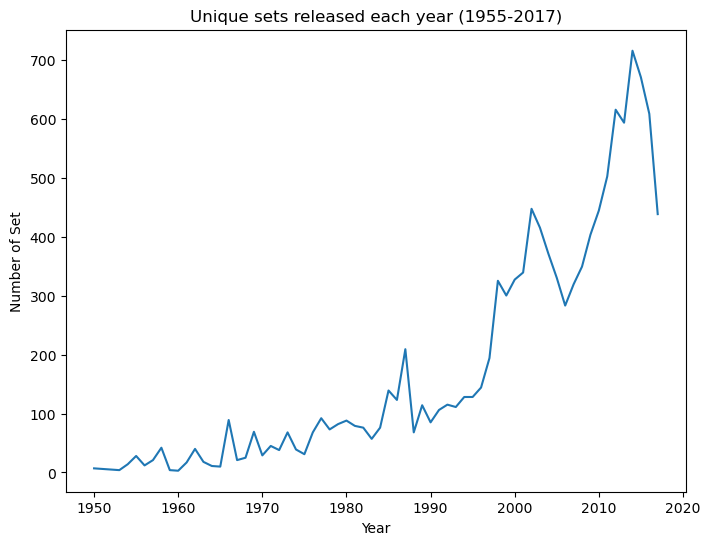

In [81]:
plt.figure(figsize = (8,6))
plt.plot('year','count', data = unique_set_by_year)
plt.xlabel('Year')
plt.ylabel('Number of Set')
plt.title('Unique sets released each year (1955-2017)')
plt.show()